# **Assignment 4. EuroSAT Land Use and Land Cover Classification**#

In this notebook, increasingly complex deep learning models are implementated to identify land use and land cover classifications on the [EuroSAT dataset](https://github.com/phelber/eurosat), a collection of 27,000 Sentinel-2 satellite images consisting of 13 spectral bands and 10 pre-labeled classes (e.g., Highway, AnnualCrop, River, Residential).[1][2]

**[1]** Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.

**[2]** Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.



## **Part A. Data Preprocessing**

- Mount Google Drive and install the Python package Rasterio that can access to geospatial raster data

- Download data from the Eurosat page: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

### **Step 1. Mount Google Drive and install the Python package Rasterio**

In [20]:
# Mount your Google Dirve
from google.colab import drive
drive.mount('/content/drive')

# Install Rasterio
!pip install rasterio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Step 2. Import related packages for image processing and deep learning model**

In [21]:
# Packages for image reading and processing
import requests  #A HTTP package for Python
import zipfile  #A zip package (craete, read, write, append a ZIP file) for Python
import io #Python package for text I/O, binary I/O and raw I/O

from PIL import Image #PIL (Python Imaging Library): image processing
from skimage.color import rgb2gray  #Collection of algorithms for image procssing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import rasterio
from rasterio.plot import show, show_hist

# Tensor processing
import numpy as np
import os
from sklearn.utils import shuffle   # sklearn: machine learning package
from sklearn.preprocessing import LabelBinarizer

# Plotting
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Deep learning modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd #pandas: data analysis package

batch_size=16
epochs=10

### **Step 3. Download and read RGB EuroSAT images from URL**


In [22]:
# RGB file URL
url="http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r=requests.get(url)
z=zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles=[]
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles=[x for x in txtfiles if ".jpg" in x]

# read images to numpy array
XImages=np.zeros([len(txtfiles), 64, 64, 3])

i=0
for pic in txtfiles:
  #Image.open() is an image opening function in the PIL module 'Image'
  XImages[i]=np.asarray(Image.open(z.open(pic))).astype('uint8')/255  #normalize image from [0, 255] to [0.0, 1.0]
  i+=1

print("The number of image:", i)
print("The shape of XImages:", XImages.shape)
del r # clear memory
del z

The number of image: 27000
The shape of XImages: (27000, 64, 64, 3)


### **Step 4. Show the downloaded images**

[[[0.21176471 0.29803922 0.35294118]
  [0.21176471 0.29803922 0.35294118]
  [0.18823529 0.2627451  0.32941176]
  ...
  [0.32941176 0.36470588 0.39215686]
  [0.21960784 0.30980392 0.33333333]
  [0.18823529 0.30196078 0.3254902 ]]

 [[0.21960784 0.29019608 0.34509804]
  [0.22352941 0.29411765 0.34901961]
  [0.18823529 0.2627451  0.32156863]
  ...
  [0.31764706 0.36862745 0.4       ]
  [0.21568627 0.31372549 0.33333333]
  [0.18823529 0.30196078 0.3254902 ]]

 [[0.30196078 0.35294118 0.38823529]
  [0.29803922 0.35294118 0.38823529]
  [0.25490196 0.31764706 0.36862745]
  ...
  [0.23137255 0.32156863 0.34509804]
  [0.2        0.30588235 0.33333333]
  [0.19215686 0.30980392 0.34117647]]

 ...

 [[0.21568627 0.30588235 0.32941176]
  [0.21568627 0.30588235 0.32941176]
  [0.22745098 0.31764706 0.34117647]
  ...
  [0.28235294 0.36078431 0.36470588]
  [0.34509804 0.4        0.40392157]
  [0.32156863 0.36862745 0.36862745]]

 [[0.23529412 0.33333333 0.34901961]
  [0.23529412 0.33333333 0.34901961]


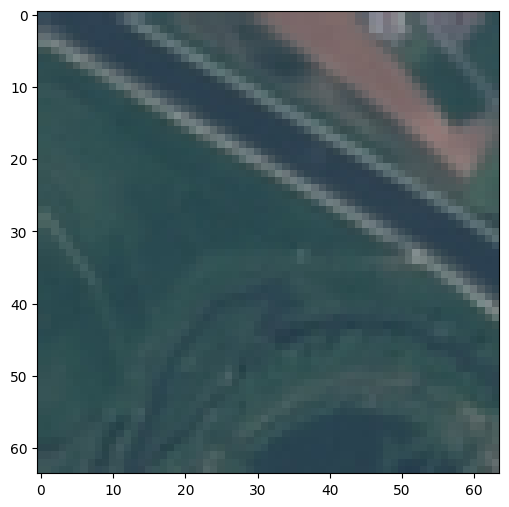

In [23]:
def plot_image(image):
  fig,ax=plt.subplots(figsize=(6,6))
  ax.imshow(image)
  plt.show()

# Call plot_image() to display an image
print(XImages[0])
plot_image(XImages[0])

### **Step 5. Get image lables**

In [24]:
# Get labels in numpy array as strings
# Example: Extract "River" from "2750/River/River_479.jpg"
labs=np.empty(len(txtfiles), dtype='S20')
i=0
for label in txtfiles:
  labs[i]=label.split('/')[1]
  i+=1

print(labs)
print(labs.shape)


'''
What does this b character in front of the string mean?

Ans. Python 3.x makes a clear distinction between the types:
-- str = '...'
-- bytes = b'...'
'''

# Change them to integers in alphabetical order

# unique()returns the sorted unique elements of an array;
# return_inverse: if true, return the indices of the unique array that can be used to reconstruct array
label_names,yLabels=np.unique(labs, return_inverse=True)

print("the shape of the label_names:", label_names.shape)
print("label_names:", label_names)
print()
print("the shape of the yLables:", yLabels.shape)
print()

label_Dict=dict(zip(np.unique(yLabels), label_names)) #create a dict: (yLabels, label_names)
print("label_Dict:",label_Dict)
print("\n")
np.array(np.unique(yLabels, return_counts=True)).T

[b'River' b'River' b'River' ... b'PermanentCrop' b'PermanentCrop'
 b'PermanentCrop']
(27000,)
the shape of the label_names: (10,)
label_names: [b'AnnualCrop' b'Forest' b'HerbaceousVegetation' b'Highway' b'Industrial'
 b'Pasture' b'PermanentCrop' b'Residential' b'River' b'SeaLake']

the shape of the yLables: (27000,)

label_Dict: {0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}




array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

### **Step 6. Show the processed images and labels**

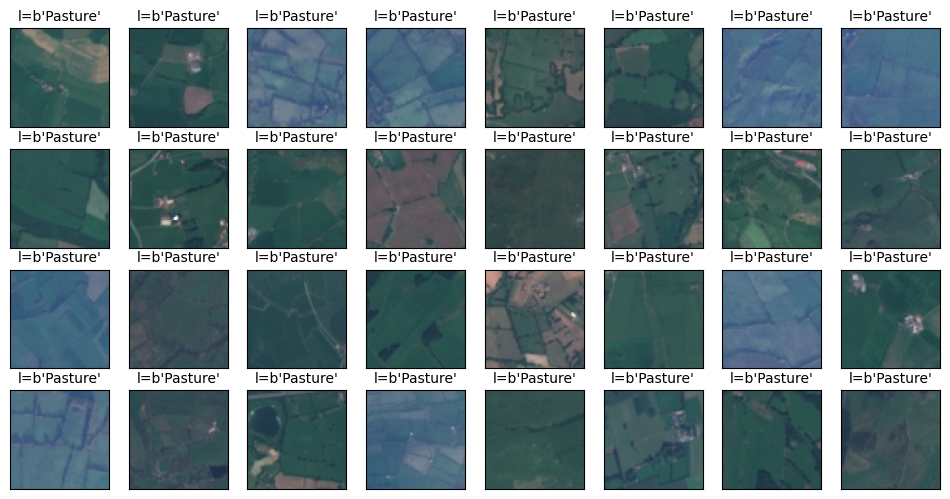

In [25]:
# Test that the labels and images read in properly
def plot_multiimages(images,labels,prediction,idx,num=32):
  fig,ax=plt.subplots(4,8,figsize=(12,6))
  if num>32:num=32 # if the number of images > 32，then set to 32 to avoid errors
  for i in range(0,num):
    ax=plt.subplot(4,8,1+i) # Build 4x8 subgraphs
    ax.imshow(images[idx],cmap='binary')
    if len(prediction)>0:
      title="l={},p={}".format(str(label_names[labels[idx]]),str(prediction[idx]))
    else:
      title="l={}".format(str(label_names[labels[idx]]))
    ax.set_title(title,fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    idx+=1 # read the next image
  plt.show()

plot_multiimages(XImages,yLabels,[],18000,32)

### **Step 7. Shuffle the datasets and balance the labels**

In [26]:
# find the smallest class
smallest_class=np.argmin(np.bincount(yLabels))
print("The class index of the smallest class:",smallest_class, label_names[smallest_class])

# number of classes
num_classes=len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs=np.where(yLabels==smallest_class)[0]

# Get 2000 observations from each class
indBal=np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp=shuffle(np.where(yLabels==i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal=np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal=shuffle(indBal, random_state=42)

yBal=yLabels[indBal]
XBal=XImages[indBal]

print(yBal.shape)
print(XBal.shape)

The class index of the smallest class: 5 b'Pasture'
(20000,)
(20000, 64, 64, 3)


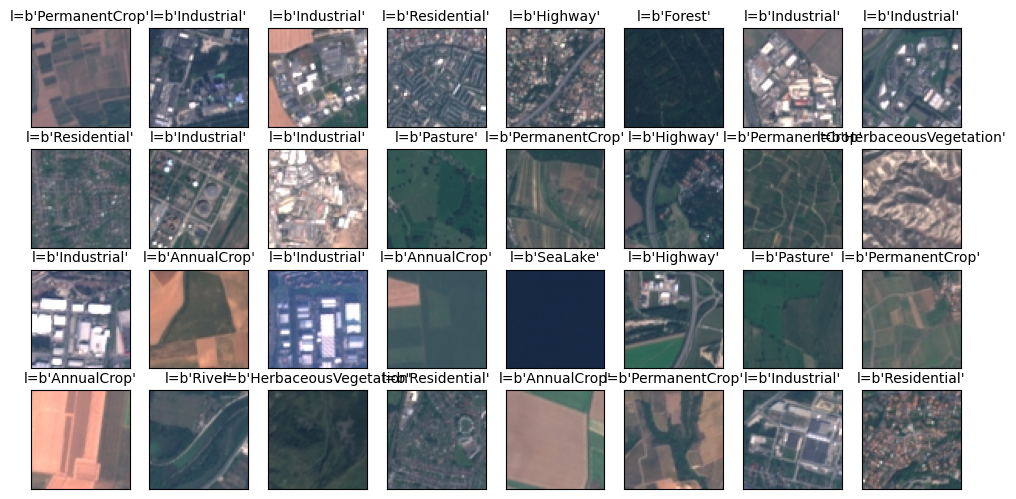

In [27]:
# first line uses balanced labels
# second line uses original imbalanced labels

# X_train, X_test, y_train, y_test=train_test_split(XBal, yBal, stratify=yBal, train_size=0.5, random_state=42)
X_train,X_test,y_train,y_test=train_test_split(XImages, yLabels, stratify=yLabels, train_size=0.5, random_state=42)

# Test that the labels and images are still matched up properly
plot_multiimages(X_train,y_train,[],300,32)

In [28]:
# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

# convert class vectors to binary class matrices
y_train=tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test=tensorflow.keras.utils.to_categorical(y_test, num_classes)

### **Part B. Model 1**

- Convert each RBG image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)

- Implement a first deep learning model `M1` using a fully connected network with a single dense layer.

- **Classification accuracy on the test data.** 26.0%

This model does not include any spatial information (i.e., pixels don't have any information about neighboring pixels).

In [29]:
# Initialize grayscale arrays
X_train_BW=np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])

X_test_BW=np.zeros([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i]=rgb2gray(X_train[i])
  X_test_BW[i]=rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW=X_train_BW.reshape(X_train_BW.shape[0], X_train_BW.shape[1]*X_train_BW.shape[2])

X_test_BW=X_test_BW.reshape(X_test_BW.shape[0], X_test_BW.shape[1]*X_test_BW.shape[2])

print("X_train_BW shape:" + str(X_train_BW.shape))
print("X_test_BW shape:" + str(X_test_BW.shape))
print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))

X_train_BW shape:(13500, 4096)
X_test_BW shape:(13500, 4096)
y_train shape:(13500, 10)
y_test shape:(13500, 10)


Implement first deep learning model

In [30]:
# save model to here
model_file='/content/drive/MyDrive/Colab Notebooks/Models/M1.h5.keras'

checkpoint=ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,970 (160.04 KB)

 Trainable params: 40,970 (160.04 KB)

 Non-trainable params: 0 (0.00 B)

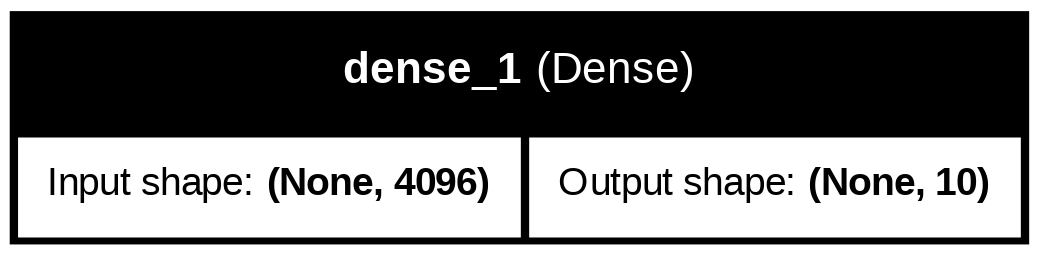

In [31]:
M1=Sequential()
M1.add(Dense(num_classes, activation='softmax', input_shape=(4096,)))
M1.summary()

plot_model(M1, show_shapes=True, show_layer_names=True)

In [32]:
M1.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

train_history_M1=M1.fit(X_train_BW, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
               callbacks=callback_list, validation_data=(X_test_BW,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1239 - loss: 2.4655 - val_accuracy: 0.1256 - val_loss: 2.6451
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1669 - loss: 2.4134 - val_accuracy: 0.2118 - val_loss: 2.5954
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1850 - loss: 2.3262 - val_accuracy: 0.2089 - val_loss: 2.2443
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2027 - loss: 2.2726 - val_accuracy: 0.2113 - val_loss: 2.3546
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2103 - loss: 2.2862 - val_accuracy: 0.1913 - val_loss: 2.3150
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2334 - loss: 2.2375 - val_accuracy: 0.2601 - val_loss: 2.2807
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2419 - loss: 2.2104 - val_accuracy: 0.2809 - val_loss: 2.1824
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2559 - loss: 2.1592 - val_accuracy: 0.

Test loss: 2.1608171463012695
Test accuracy: 0.27311110496520996


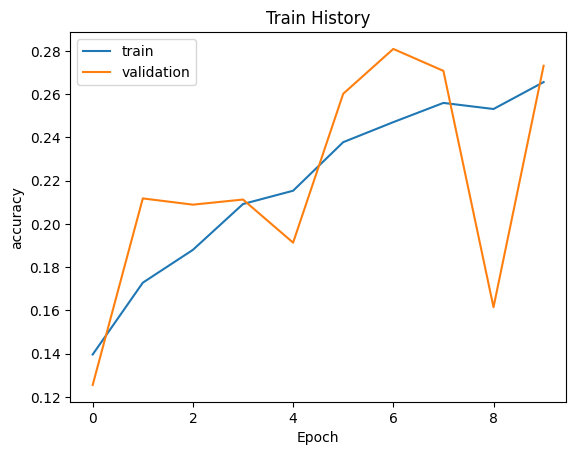

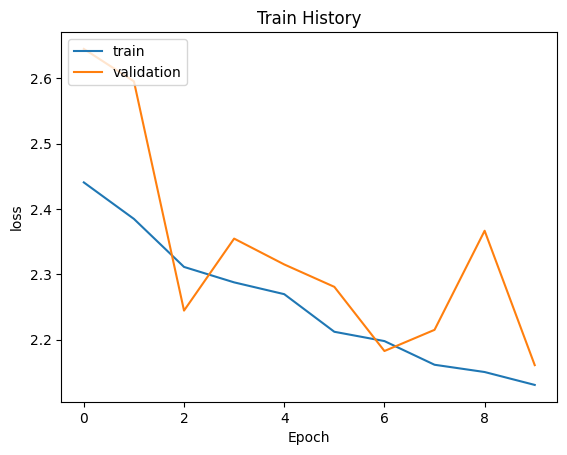

In [33]:
score=M1.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

def show_train_history(train_history,train,validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel(train)
  plt.xlabel('Epoch')
  plt.legend(['train','validation'],loc='upper left')
  plt.show()

show_train_history(train_history_M1,'accuracy','val_accuracy')
show_train_history(train_history_M1,'loss','val_loss')

In [34]:
y_test_true_tmp=np.argmax(y_test, axis=1)
label_count=np.unique(y_test_true_tmp, return_counts=True)[1]

In [35]:
# Define functions for evaluating model accuracy by class and overall
def eval_model_by_class(model, test_set):
  y_test_pred_tmp=np.argmax(model.predict(test_set),axis=-1)

  y_test_true=[label_Dict[x] for x in y_test_true_tmp]
  y_test_pred=[label_Dict[x] for x in y_test_pred_tmp]

  pred_df=pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds']=pred_df.y_true==pred_df.y_pred
  pred_df=pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count']=label_count
  pred_df['class_acc']=pred_df.accurate_preds/pred_df.label_count
  pred_df=pred_df.sort_values(by='class_acc').reset_index()
  pred_df['overall_acc']=sum(pred_df.accurate_preds)/sum(pred_df.label_count)
  pred_df=pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred_tmp=np.argmax(model.predict(test_set),axis=-1)

  y_test_true=[label_Dict[x] for x in y_test_true_tmp]
  y_test_pred=[label_Dict[x] for x in y_test_pred_tmp]

  pred_df=pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds']=pred_df.y_true==pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df=pred_df.sort_values('y_true')

  return(pred_df)

In [36]:
M1_pred_df=eval_model_by_class(M1, X_test_BW)
M1_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropPermanentCropPermanentCropAnnualCr...,499,1500,0.332667,0.273111
1,1,b'Forest',b'ForestForestForestHerbaceousVegetationForest...,1229,1500,0.819333,0.273111
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationHerbaceousVegetationPerm...,758,1500,0.505333,0.273111
3,3,b'Highway',b'AnnualCropHerbaceousVegetationPermanentCropA...,0,1250,0.000000,0.273111
4,4,b'Industrial',b'IndustrialAnnualCropHerbaceousVegetationIndu...,546,1250,0.436800,0.273111
5,5,b'Pasture',b'HerbaceousVegetationHerbaceousVegetationHerb...,0,1000,0.000000,0.273111
6,6,b'PermanentCrop',b'AnnualCropAnnualCropHerbaceousVegetationPerm...,345,1250,0.276000,0.273111
7,7,b'Residential',b'PermanentCropPermanentCropHerbaceousVegetati...,0,1500,0.000000,0.273111
8,8,b'River',b'AnnualCropHerbaceousVegetationHerbaceousVege...,310,1250,0.248000,0.273111
9,9,b'SeaLake',b'ForestHerbaceousVegetationForestForestHerbac...,0,1500,0.000000,0.273111


### **Part B. Model 2**

- Implement a second deep learning model `M2` adding an additional dense layer to the previous model.

- **Classification accuracy on the test data.** 26.7%

In [37]:
model_file='/content/drive/My Drive/Colab Notebooks/Models/M2.h5.keras'

checkpoint=ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,051,402 (4.01 MB)

 Trainable params: 1,051,402 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

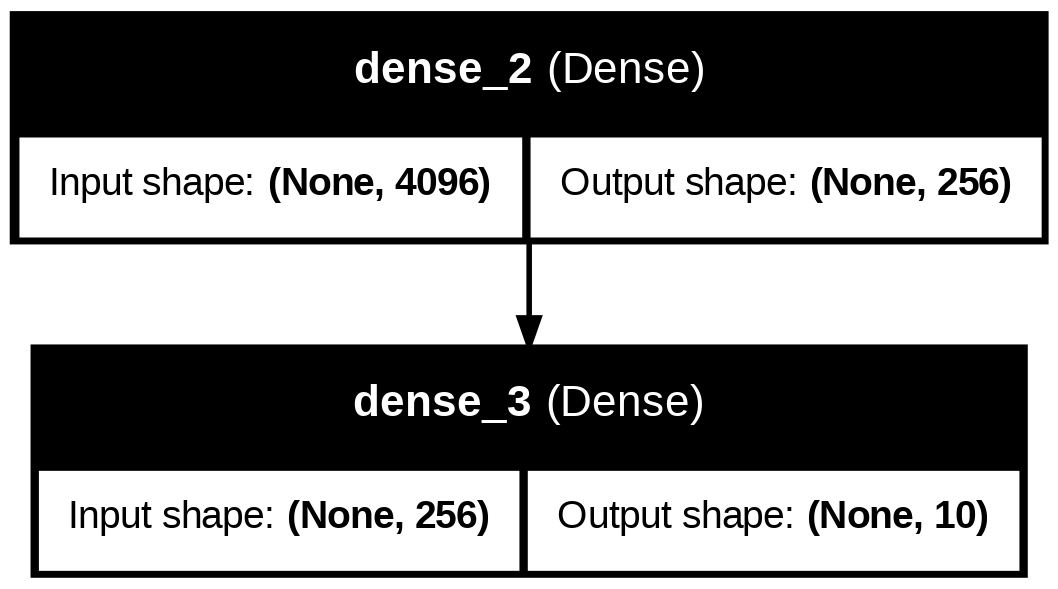

In [38]:
M2=Sequential()
M2.add(Dense(256, activation='relu', input_shape=(4096,)))
M2.add(Dense(num_classes, activation='softmax'))

M2.summary()
plot_model(M2, show_shapes=True, show_layer_names=True)

In [39]:
M2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
train_history_M2=M2.fit(X_train_BW, y_train, batch_size=batch_size, epochs=epochs,
               callbacks=callback_list, verbose=1, validation_data=(X_test_BW,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1084 - loss: 2.3985 - val_accuracy: 0.1111 - val_loss: 2.2957
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1075 - loss: 2.2952 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1086 - loss: 2.2947 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0998 - loss: 2.2957 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1071 - loss: 2.2948 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1068 - loss: 2.2937 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1063 - loss: 2.2966 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1085 - loss: 2.2981 - val_accuracy: 0.

Test loss: 2.2947945594787598
Test accuracy: 0.1111111119389534


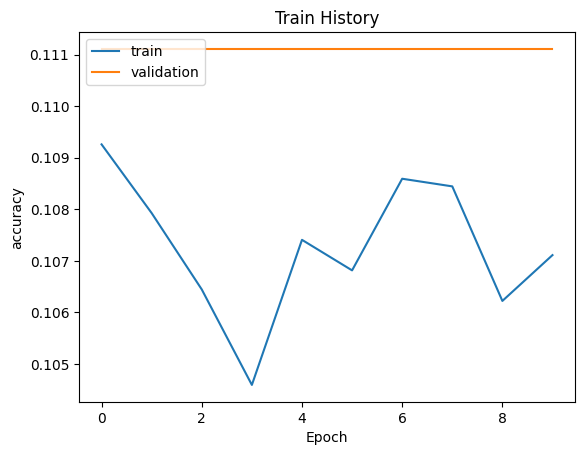

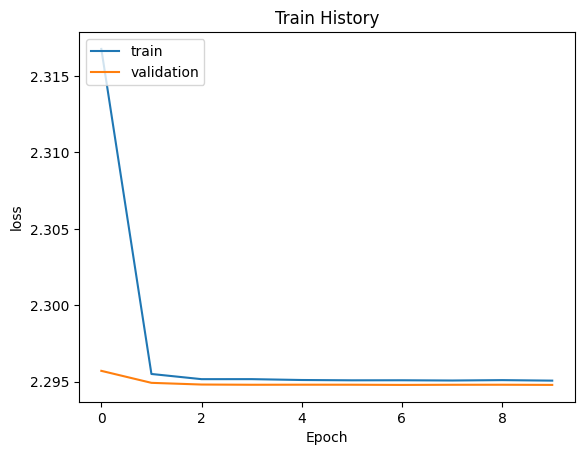

In [40]:
score=M2.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M2,'accuracy','val_accuracy')
show_train_history(train_history_M2,'loss','val_loss')

In [41]:
M2_pred_df=eval_model_by_class(M2, X_test_BW)
M2_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1500,0.0,0.111111
1,1,b'Forest',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1500,0.0,0.111111
2,2,b'HerbaceousVegetation',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1500,0.0,0.111111
3,3,b'Highway',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1250,0.0,0.111111
4,4,b'Industrial',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1250,0.0,0.111111
5,5,b'Pasture',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1000,0.0,0.111111
6,6,b'PermanentCrop',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1250,0.0,0.111111
7,7,b'Residential',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1500,0.0,0.111111
8,8,b'River',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,0,1250,0.0,0.111111
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1500,1500,1.0,0.111111


### **Part B. Model 3**

- Implement a third deep learning model `M3` adding two additional dense layers as well as drop-out layers to the previous model.

- **Classification accuracy on the test data.** 11.1%
- **Compare against previous models. Which model was the "best"? Why?** Of the first three models, `M2` was the best. It had a higher accuracy on the test data, and based on the plots showing training/testing loss and accuracy, it fit the data better than either Models M1 or M3, which both showed large fluctuations in the testing loss and accuracy.

In [42]:
model_file='/content/drive/MyDrive/Colab Notebooks/Models/M3.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,182,986 (4.51 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

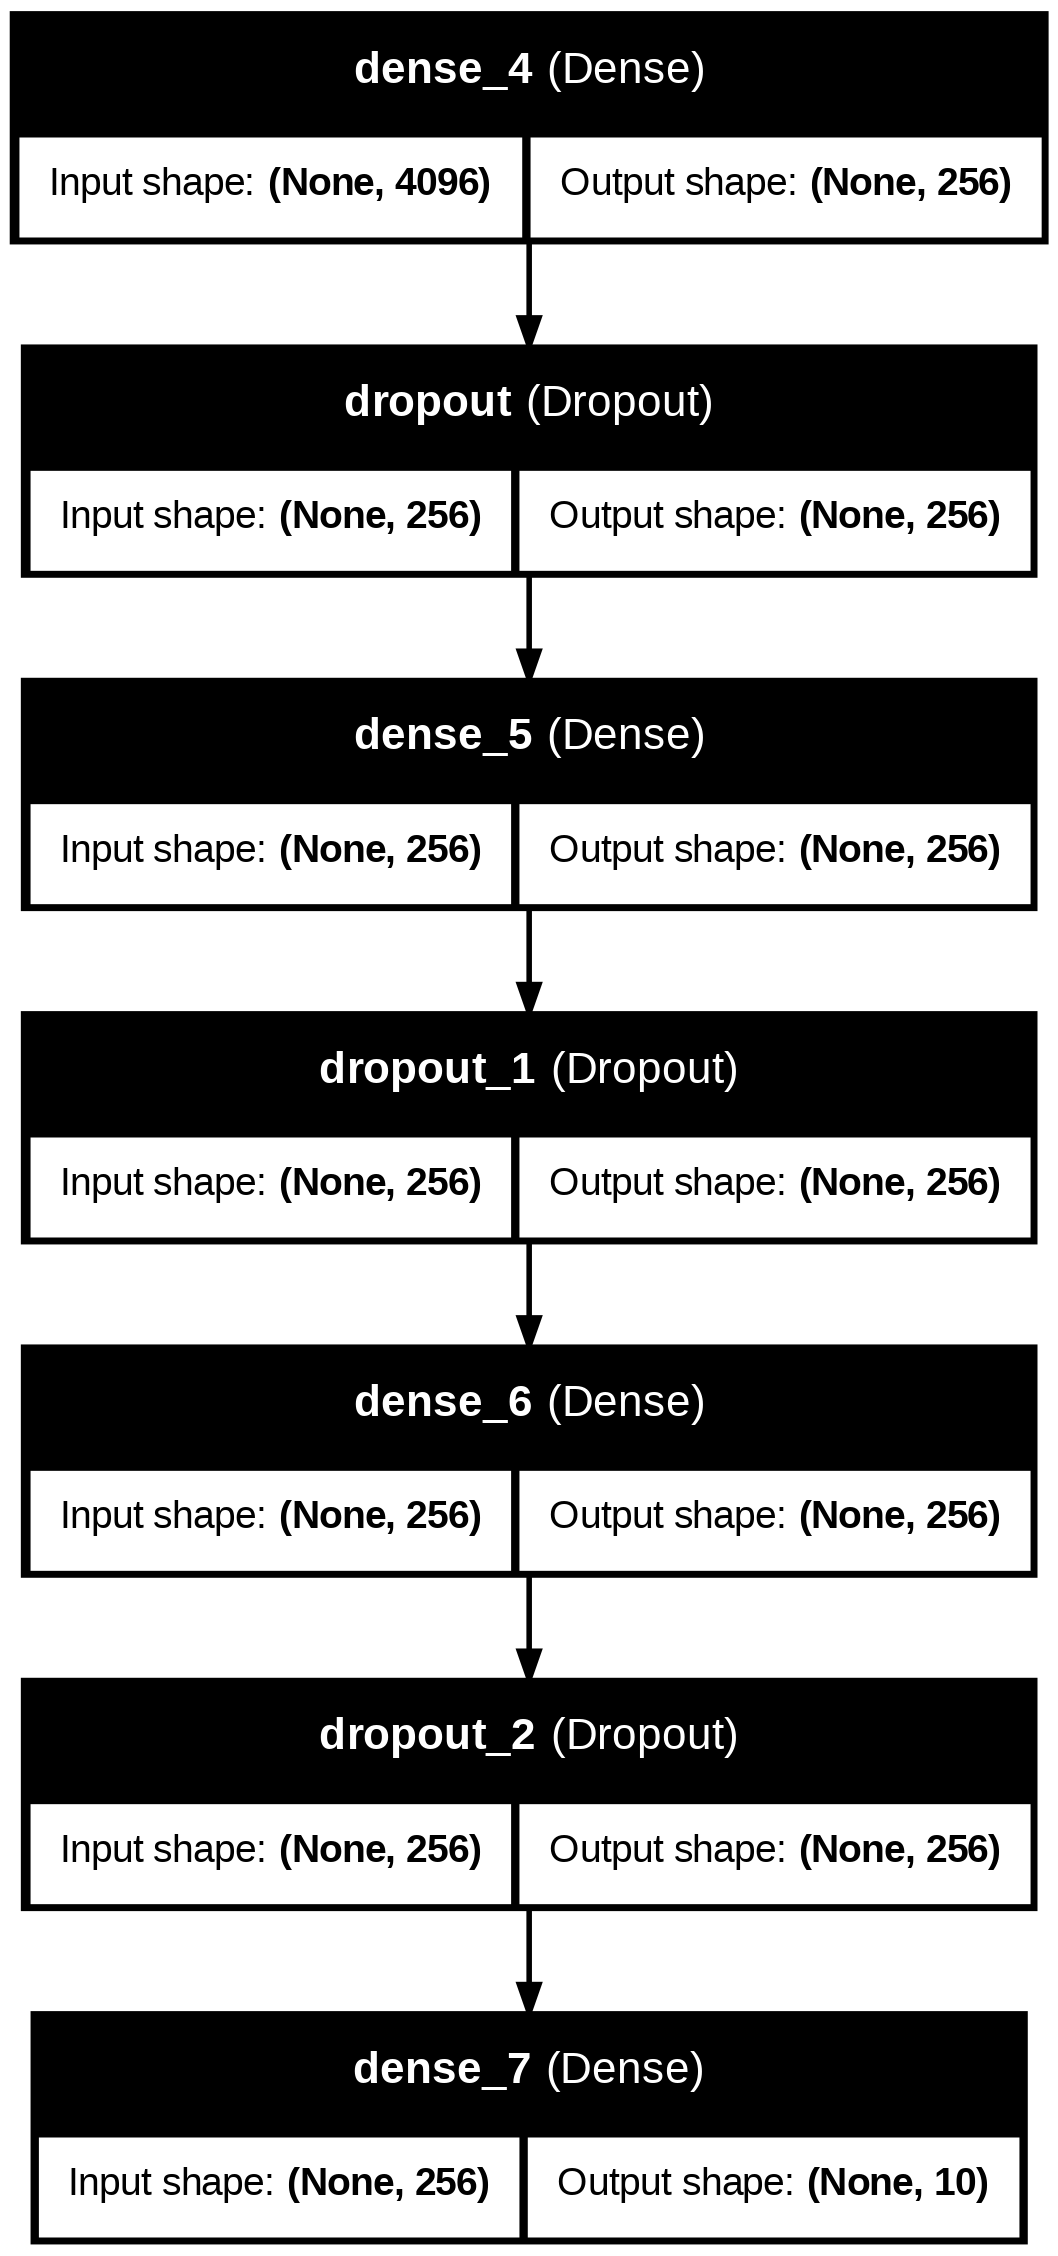

In [43]:
M3=Sequential()
M3.add(Dense(256, activation='relu', input_shape=(4096,)))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(num_classes, activation='softmax'))

M3.summary()

plot_model(M3, show_shapes=True, show_layer_names=True)

In [44]:
M3.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

train_history_M3=M3.fit(X_train_BW, y_train, batch_size=batch_size, epochs=epochs,
               callbacks=callback_list, verbose=1, validation_data=(X_test_BW,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.1091 - loss: 2.3609 - val_accuracy: 0.1111 - val_loss: 2.2957
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1094 - loss: 2.2958 - val_accuracy: 0.1111 - val_loss: 2.2958
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1074 - loss: 2.2948 - val_accuracy: 0.1111 - val_loss: 2.2951
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1074 - loss: 2.2970 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1087 - loss: 2.2946 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1040 - loss: 2.2962 - val_accuracy: 0.1111 - val_loss: 2.2950
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1086 - loss: 2.2954 - val_accuracy: 0.1111 - val_loss: 2.2951
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1126 - loss: 2.2957 - val_accuracy: 

Test loss: 2.2948524951934814
Test accuracy: 0.1111111119389534


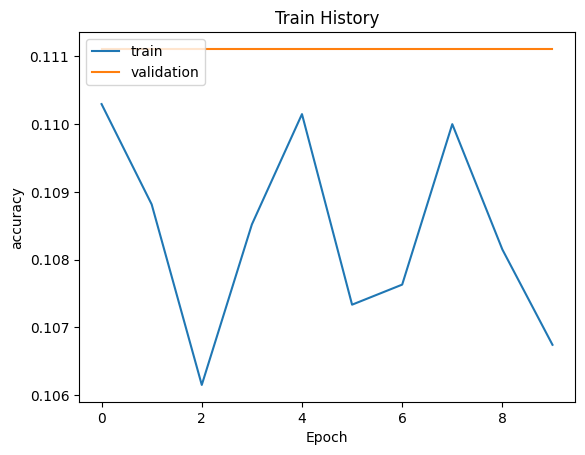

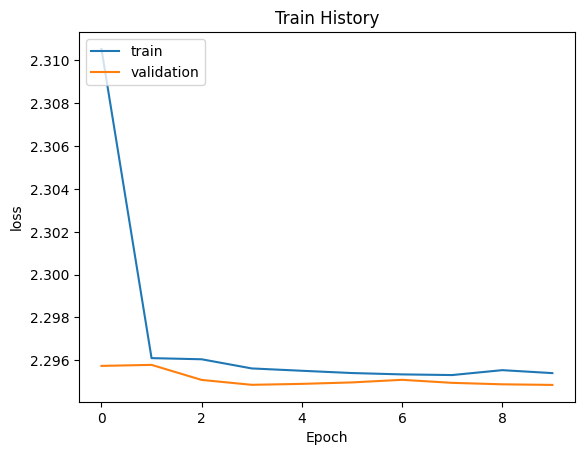

In [45]:
score=M3.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M3,'accuracy','val_accuracy')
show_train_history(train_history_M3,'loss','val_loss')

In [46]:
M3_pred_df=eval_model_by_class(M3, X_test_BW)
M3_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111
1,1,b'Forest',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111
2,2,b'HerbaceousVegetation',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111
3,3,b'Highway',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
4,4,b'Industrial',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
5,5,b'Pasture',b'ResidentialResidentialResidentialResidential...,0,1000,0.0,0.111111
6,6,b'PermanentCrop',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1500,1500,1.0,0.111111
8,8,b'River',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
9,9,b'SeaLake',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111


### **Part B. Model 4**

- Using RGB images (without vectorizing them), implement a fourth model `M4` that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense.

- **Classification accuracy on the test data.** 77.6%
- **Compare against previous models. Which model was the "best"? Why?** Model `M4` is clearly the best so far, with a testing accuracy of 76.2%. The inclusion of the convolutional and maxpooling layers added a spatial component to the model, boosting the predictive power significantly. Based on the divergence of the training/testing loss and accuracy plots, the model started overfitting the training data after 10 or so epochs.

In [47]:
input_shape=X_train.shape[1:]

model_file='/content/drive/MyDrive/Colab Notebooks/Models/M4.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,767,818 (56.33 MB)

 Trainable params: 14,767,818 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

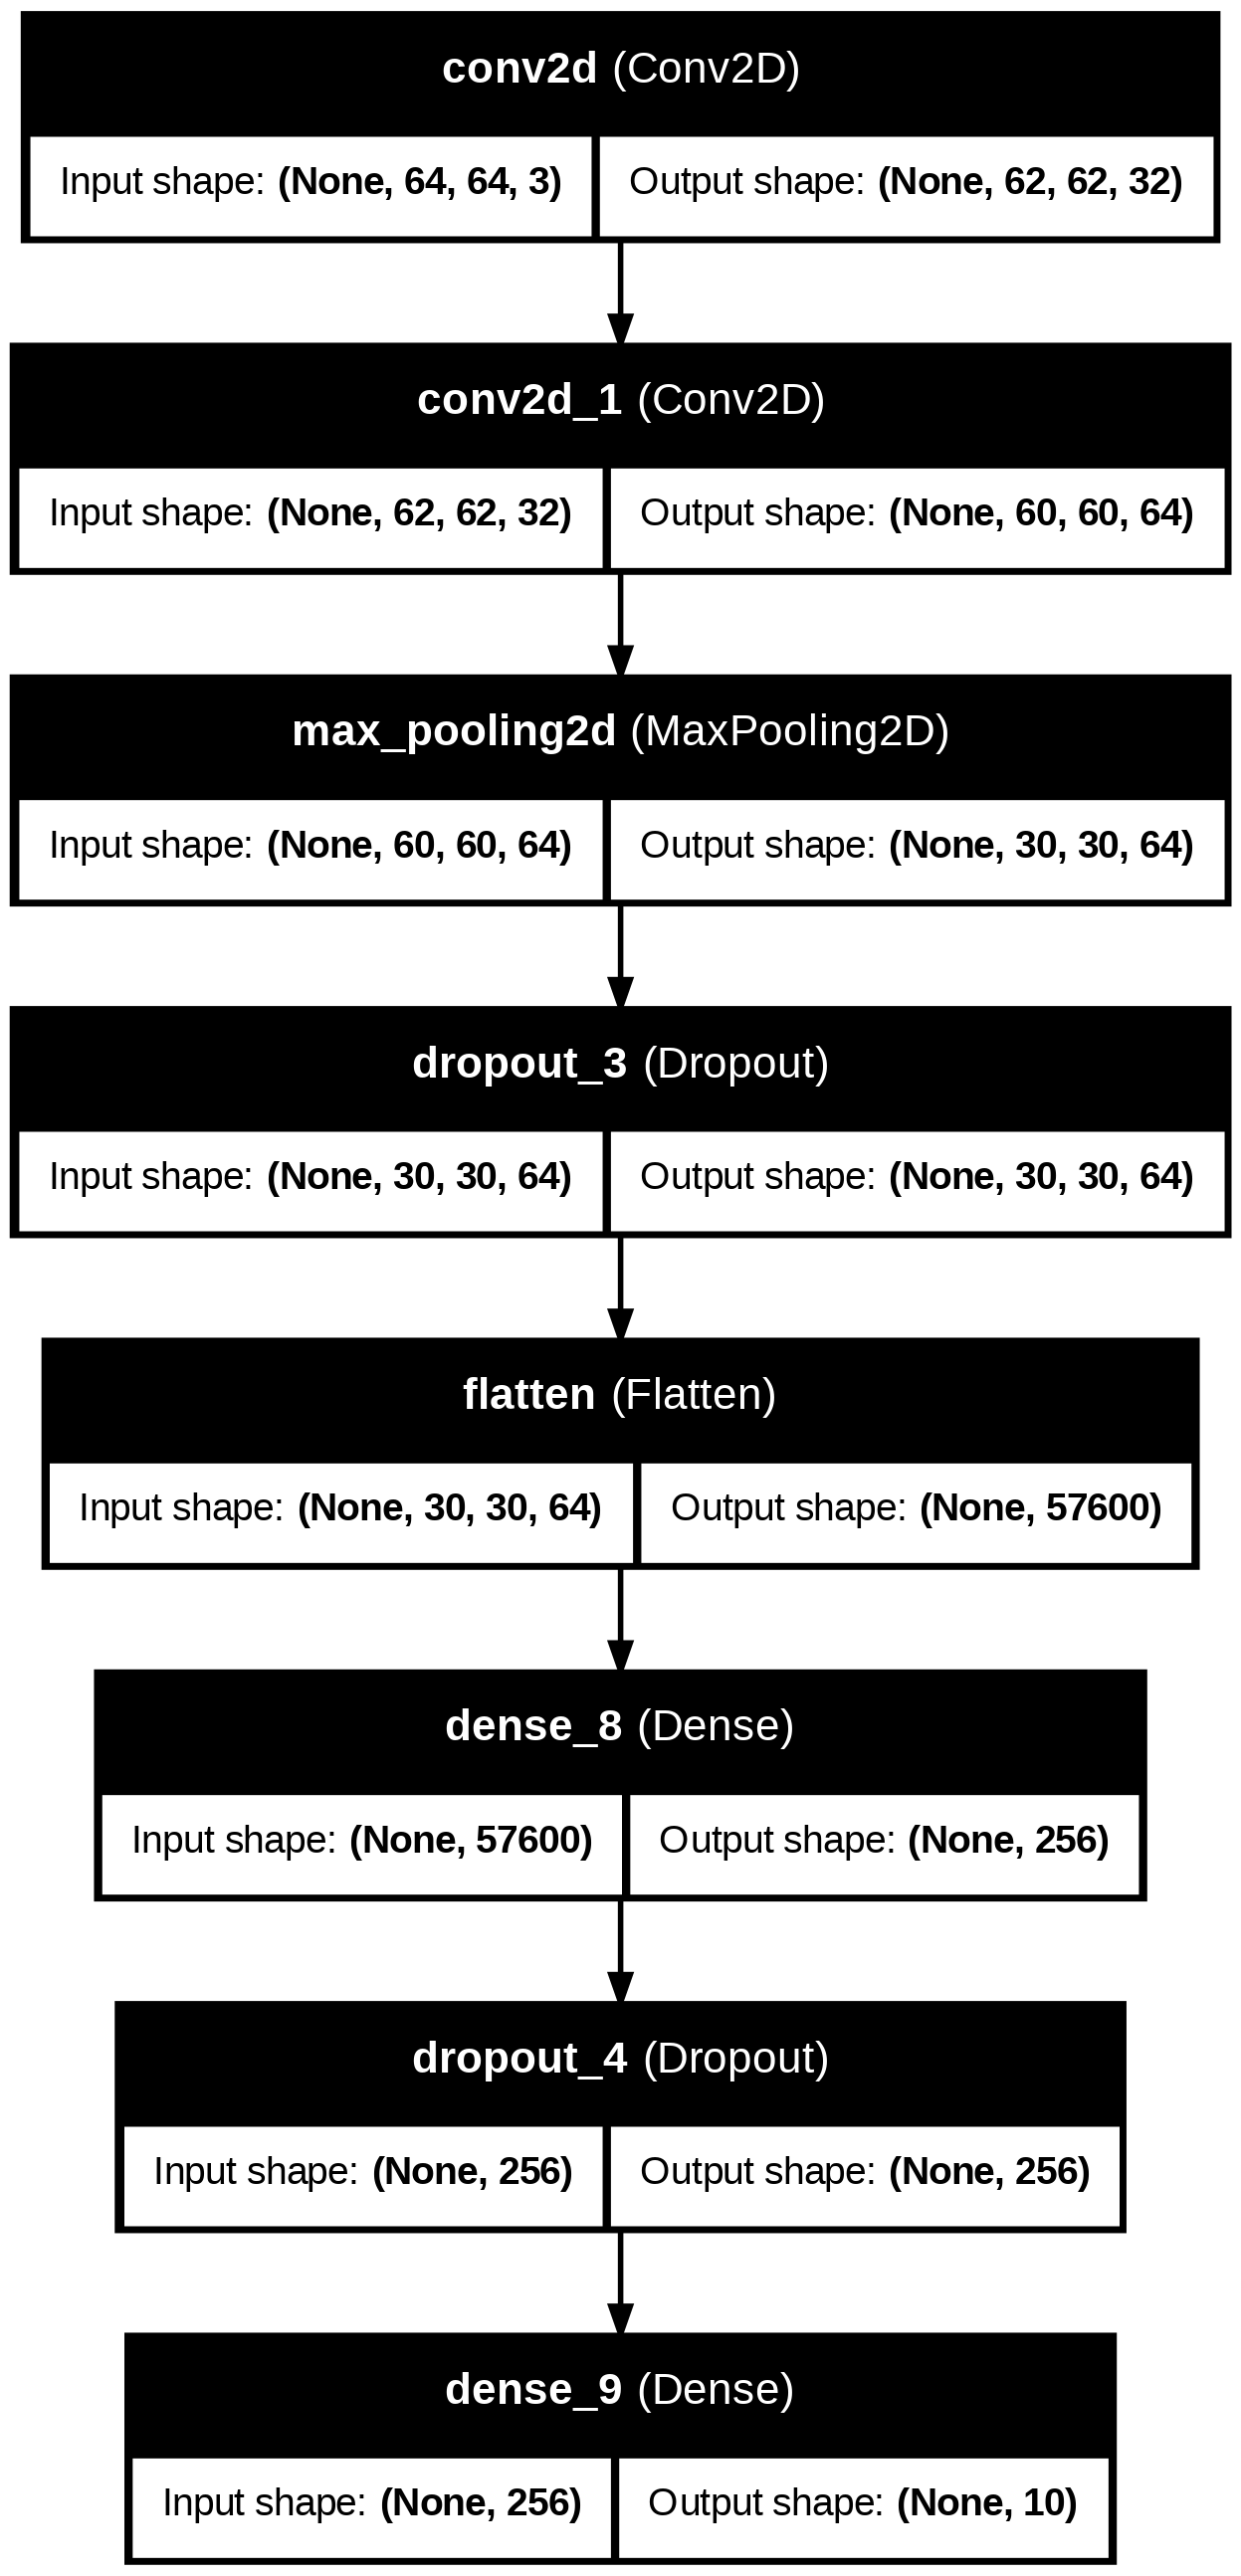

In [48]:
M4=Sequential()
M4.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
M4.add(Conv2D(64, (3,3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2,2)))
M4.add(Dropout(0.2))
M4.add(Flatten())
M4.add(Dense(256, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(num_classes, activation='softmax'))

M4.summary()

plot_model(M4,show_shapes=True,show_layer_names=True)

In [49]:
M4.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

train_history_M4=M4.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,
               callbacks=callback_list,verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.3859 - loss: 1.6324 - val_accuracy: 0.6647 - val_loss: 0.9041
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7263 - loss: 0.7836 - val_accuracy: 0.7507 - val_loss: 0.6869
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8116 - loss: 0.5506 - val_accuracy: 0.7701 - val_loss: 0.6673
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8554 - loss: 0.4088 - val_accuracy: 0.7804 - val_loss: 0.6771
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9006 - loss: 0.2940 - val_accuracy: 0.7923 - val_loss: 0.6937
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9299 - loss: 0.2136 - val_accuracy: 0.7701 - val_loss: 0.8949
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9438 - loss: 0.1710 - val_accuracy: 0.7404 - val_loss: 1.0107
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9445 - loss: 0.1663 - val_accuracy: 

Test loss: 1.2489839792251587
Test accuracy: 0.757777750492096


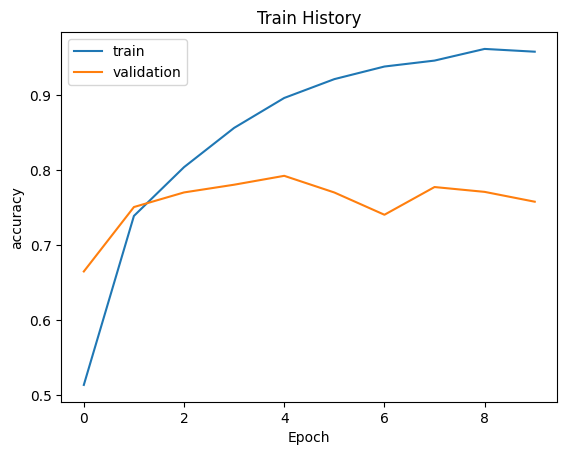

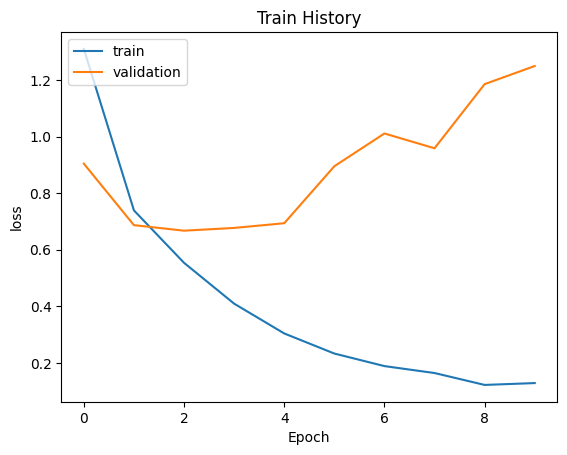

In [50]:
score=M4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M4,'accuracy','val_accuracy')
show_train_history(train_history_M4,'loss','val_loss')

In [51]:
M4_pred_df=eval_model_by_class(M4, X_test)
M4_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropAnnualCropAnnualCropAnnualCropAnnu...,1286,1500,0.857333,0.757778
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1436,1500,0.957333,0.757778
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationPermanentCropPermanentCr...,810,1500,0.540000,0.757778
3,3,b'Highway',b'HighwayHighwayResidentialHerbaceousVegetatio...,757,1250,0.605600,0.757778
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1204,1250,0.963200,0.757778
5,5,b'Pasture',b'HighwayPasturePasturePasturePasturePastureRi...,771,1000,0.771000,0.757778
6,6,b'PermanentCrop',b'PermanentCropAnnualCropPermanentCropPermanen...,651,1250,0.520800,0.757778
7,7,b'Residential',b'ResidentialResidentialIndustrialResidentialI...,1362,1500,0.908000,0.757778
8,8,b'River',b'RiverPastureIndustrialRiverHighwayRiverRiver...,550,1250,0.440000,0.757778
9,9,b'SeaLake',b'SeaLakePastureSeaLakeSeaLakeSeaLakeSeaLakeSe...,1403,1500,0.935333,0.757778


### **Models 5-8**

- Using RGB images (without vectorizing them), implement a deep learning model targeting accuracy that will outperform all previous models.

- **Describe the model you built, and why you chose it.** I built five more models
  - _M5:_ A model with 4 convolution-maxpooling layer pairs before a dropout layer and a dense layer. I added the additional convolutions to try to extract larger features in each image.
  - _M6:_ This model is M5, but I replaced the convolutional layers with the convolutional base of the `VGG16` model instead.[3] I ran this once with the pre-loaded weights, and I ran it again with some of the convolutional layers in VGG16 unfrozen and a lower learning rate to extract some of the lower level features from the EuroSAT images. Unfreezing the weights improved the model by about 1.6 percentage points. I created this model to see (1) the effect transfer learning would have on my accuracy and (2) the improvements I could get from fine-tuning the pre-loaded weights.
  - _M7:_ This model is the same as M6 but uses training data that has been augmented through random shearing, rotating, and flipping. I wanted to see if this would improve the overfitting I'd been seeing in some of my models.
  - _M8:_ It has the same layers and data augmentation as M7, but it also includes two callbacks: `EarlyStopping` to reduce overfitting and keep the weights from the epoch with the lowest validation loss and `ReduceLROnPlateau` to decay the learning rate as validation loss improvements slow.

- **Classification accuracy on the test data.**
  - _M5:_ 85.4%
  - _M6:_ 92.1% with pre-loaded VGG16 weights and 87.2% with additional fine-tuning
  - _M7:_ 96.6%
  - _M8:_ 97.8%

- **Compare against previous models. Which model was the "best"? Why?** M8, which uses VGG16's convolutional base, augmented data, and callbacks, had the best performance. In terms of accuracy, it correctly classified 94.5% of the test set. Based on the training/testing accuracy and loss plots, the two models with callbacks clearly performed better from an overfitting perspective. The decay in the learning rate also helped the model make marginal improvements in validation loss more quickly than previous models. Lastly, EarlyStopping reduced the training time and allowed me to retain the weights from the epoch with the lowest validation loss.

- **What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.** The highest errors were in the SeaLake and AnnualCrop images, which both had accuracies in the low 90's, well below the other categories. As shown in the examples, they were most often confused with Forest and PermanentCrop/Pasture, respectively.

**[3]** Very Deep Convolutional Networks for Large-Scale Image Recognition
K. Simonyan, A. Zisserman
arXiv:1409.1556

### **Part B. Model 5**

In [52]:
model_file='/content/drive/MyDrive/Colab Notebooks/Models/M5.h5.keras'

checkpoint=ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

In [53]:
input_shape=X_train.shape[1:]
M5 = Sequential()
M5.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Conv2D(64, (3,3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Conv2D(128, (3,3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Conv2D(256, (3,3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Flatten())
M5.add(Dropout(0.5))
M5.add(Dense(512, activation='relu'))
# M5.add(Dropout(0.2))
M5.add(Dense(num_classes, activation='softmax'))

M5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 918,346 (3.50 MB)

 Trainable params: 918,346 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
M5.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

train_history_M5=M5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              callbacks=callback_list, verbose=1, validation_data=(X_test,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3353 - loss: 1.6887 - val_accuracy: 0.6037 - val_loss: 1.0372
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6002 - loss: 1.0640 - val_accuracy: 0.6686 - val_loss: 0.8917
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6937 - loss: 0.8602 - val_accuracy: 0.7527 - val_loss: 0.6828
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7329 - loss: 0.7397 - val_accuracy: 0.7826 - val_loss: 0.6085
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7616 - loss: 0.6609 - val_accuracy: 0.6447 - val_loss: 1.0299
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7965 - loss: 0.5841 - val_accuracy: 0.8210 - val_loss: 0.5224
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8234 - loss: 0.4996 - val_accuracy: 0.8270 - val_loss: 0.4908
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8250 - loss: 0.4971 - val_accuracy: 

Test loss: 0.5203078985214233
Test accuracy: 0.8235555291175842


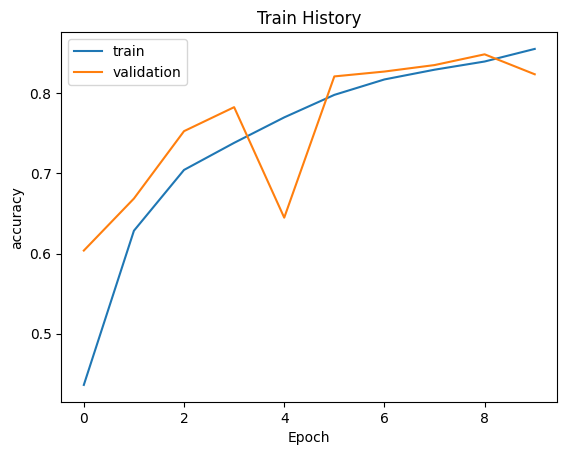

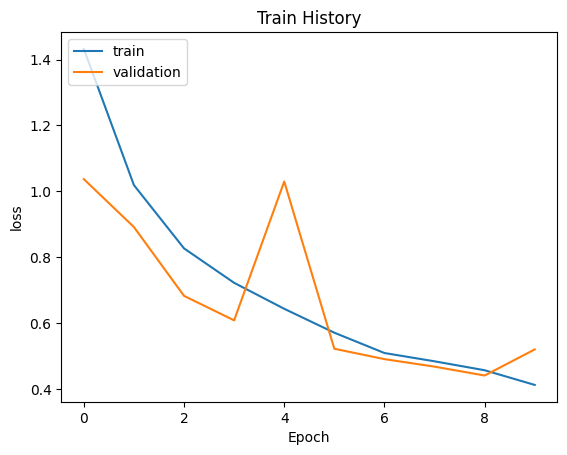

In [55]:
score=M5.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M5,'accuracy','val_accuracy')
show_train_history(train_history_M5,'loss','val_loss')

In [56]:
M5_pred_df=eval_model_by_class(M5, X_test)
M5_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropAnnualCropAnnualCropAnnualCropAnnu...,1246,1500,0.830667,0.823556
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1448,1500,0.965333,0.823556
2,2,b'HerbaceousVegetation',b'PermanentCropPermanentCropHerbaceousVegetati...,1226,1500,0.817333,0.823556
3,3,b'Highway',b'HerbaceousVegetationHighwayIndustrialHighway...,894,1250,0.715200,0.823556
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1220,1250,0.976000,0.823556
5,5,b'Pasture',b'HerbaceousVegetationPasturePasturePastureRiv...,462,1000,0.462000,0.823556
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,776,1250,0.620800,0.823556
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1441,1500,0.960667,0.823556
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,950,1250,0.760000,0.823556
9,9,b'SeaLake',b'SeaLakePastureSeaLakeSeaLakeSeaLakeSeaLakeSe...,1455,1500,0.970000,0.823556


### **Part B. Model 6:** Use `VGG16` convolutional base for Transfer Learning

In [57]:
conv_base=vgg16.VGG16(include_top=False,input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [58]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# how many layers are trainable in the VGG16 model?
len(conv_base.trainable_weights)

26

In [60]:
# freeze the weights
for layer in conv_base.layers:
  layer.trainable=False

In [61]:
# now there are 0
len(conv_base.trainable_weights)

0

In [62]:
model_file='/content/drive/MyDrive/Colab Notebooks/Models/M6.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

In [63]:
input_shape=X_train.shape[1:]
M6=Sequential()

M6.add(Input(shape=input_shape))
M6.add(conv_base)

M6.add(Flatten())
M6.add(Dropout(0.5))
M6.add(Dense(512, activation='relu'))
M6.add(Dense(num_classes, activation='softmax'))

M6.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,768,906 (60.15 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [64]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [65]:
M6.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
train_history_M6=M6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
               callbacks=callback_list, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6160 - loss: 1.0843 - val_accuracy: 0.7773 - val_loss: 0.6163
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7656 - loss: 0.6609 - val_accuracy: 0.8143 - val_loss: 0.5328
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7821 - loss: 0.6055 - val_accuracy: 0.8244 - val_loss: 0.4952
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7993 - loss: 0.5675 - val_accuracy: 0.8223 - val_loss: 0.5089
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8006 - loss: 0.5513 - val_accuracy: 0.8236 - val_loss: 0.4966
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8140 - loss: 0.5137 - val_accuracy: 0.8430 - val_loss: 0.4543
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8217 - loss: 0.5074 - val_accuracy: 0.8398 - val_loss: 0.4544
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8217 - loss: 0.4937 - val_accuracy: 

Test loss: 0.44071170687675476
Test accuracy: 0.8447407484054565


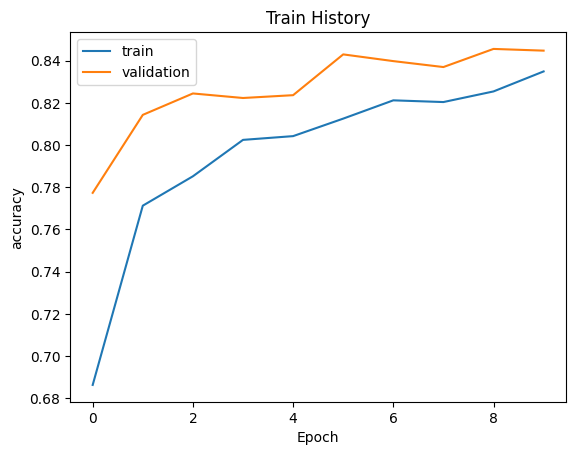

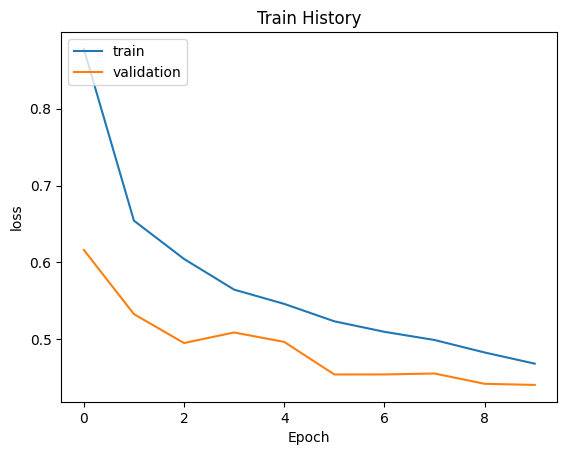

In [66]:
score=M6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M6,'accuracy','val_accuracy')
show_train_history(train_history_M6,'loss','val_loss')

**Model 6 (Part II):** Unfreeze some layers in the convolutional base

In [67]:
# how many layers are trainable in the VGG16 model?
len(conv_base.trainable_weights)

# unfreeze the latter 2/3ds of the base
for layer in conv_base.layers[7:]:
  layer.trainable = True

len(conv_base.trainable_weights)

18

In [68]:
# set a lower learning rate to minimize magnitude of changes to weights
M6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

train_history_M6=M6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
               verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6344 - loss: 1.1449 - val_accuracy: 0.8032 - val_loss: 0.6339
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8722 - loss: 0.3988 - val_accuracy: 0.9259 - val_loss: 0.2470
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9245 - loss: 0.2473 - val_accuracy: 0.9111 - val_loss: 0.3408
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9420 - loss: 0.1867 - val_accuracy: 0.9351 - val_loss: 0.2083
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9449 - loss: 0.1809 - val_accuracy: 0.8660 - val_loss: 0.4045
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9557 - loss: 0.1378 - val_accuracy: 0.9337 - val_loss: 0.2168
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9605 - loss: 0.1331 - val_accuracy: 0.9240 - val_loss: 0.2581
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9603 - loss: 0.1285 - val_accuracy: 

Test loss: 0.26572588086128235
Test accuracy: 0.9269629716873169


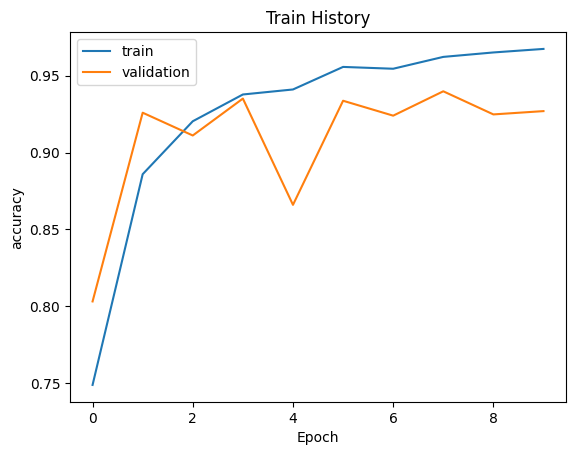

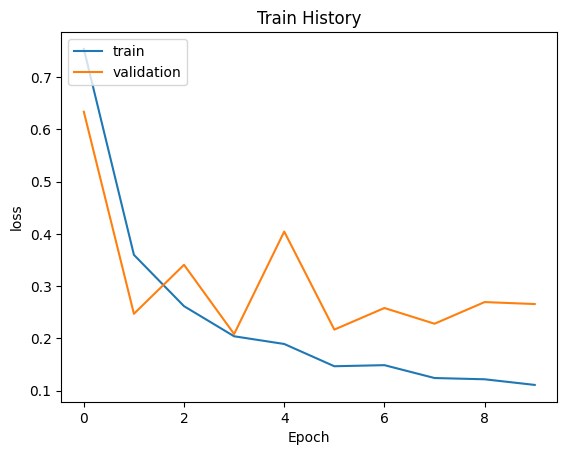

In [69]:
score=M6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M6,'accuracy','val_accuracy')
show_train_history(train_history_M6,'loss','val_loss')

In [70]:
M6_pred_df=eval_model_by_class(M6, X_test)

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


### **Part B. Model 7:** Model 6 (all trainable)+Data Augmentation

In [71]:
model_file='/content/drive/MyDrive/Colab Notebooks/Models/M7.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

In [72]:
M7=Sequential()

conv_base=vgg16.VGG16(include_top=False, input_shape=input_shape)

M7.add(conv_base)

M7.add(Flatten())
M7.add(Dropout(0.5))
M7.add(Dense(512,activation='relu'))
M7.add(Dense(num_classes,activation='softmax'))

M7.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

for layer in conv_base.layers[7:]:
  layer.trainable = True

In [73]:
train_datagen=ImageDataGenerator(
    # rescale=1. / 255,
#    shear_range=0.2,
#    zoom_range=0.2,
#    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen=ImageDataGenerator()

train_generator=train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    seed=42)

test_generator=test_datagen.flow(
    X_test,
    y_test,
    batch_size=batch_size,
    seed=42)

train_history_M7=M7.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            callbacks=callback_list,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


843/843 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.5774 - loss: 1.2007 - val_accuracy: 0.8810 - val_loss: 0.3913
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9375 - loss: 0.2058

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9375 - loss: 0.2058 - val_accuracy: 0.7500 - val_loss: 0.5108
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8898 - loss: 0.3699 - val_accuracy: 0.9310 - val_loss: 0.2283
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.9081 - val_accuracy: 1.0000 - val_loss: 0.1083
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9307 - loss: 0.2355 - val_accuracy: 0.9245 - val_loss: 0.2545
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.1805 - val_accuracy: 1.0000 - val_loss: 0.0854
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9296 - loss: 0.2500 - val_accuracy: 0.9422 - val_loss: 0.1955
Epoch 8/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 1.0000 - loss: 0.0807 - val_accuracy: 1.0000 - val_loss: 0.0889
Epoch 9/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9468 - loss: 0.1791 - val_accuracy: 0.9570

Test loss: 0.14262403547763824
Test accuracy: 0.9557036757469177


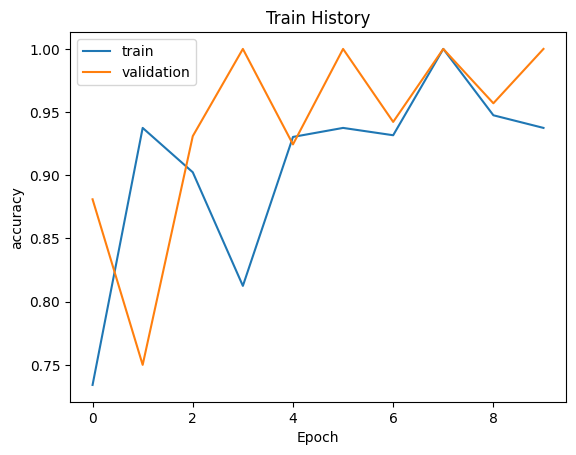

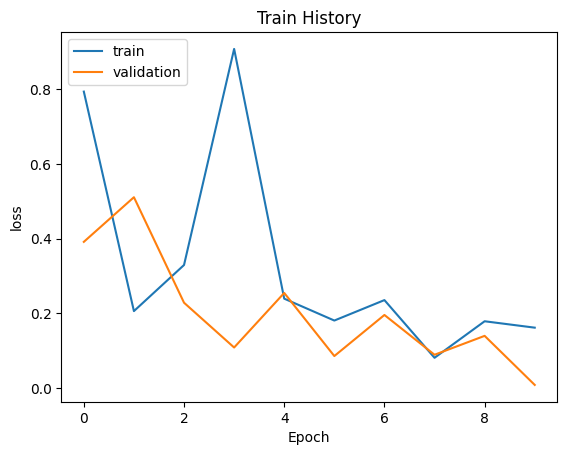

In [74]:
score=M7.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M7,'accuracy','val_accuracy')
show_train_history(train_history_M7,'loss','val_loss')

In [75]:
M7_pred_df=eval_model_by_class(M7, X_test)
M7_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropAnnualCropAnnualCropAnnualCropAnnu...,1437,1500,0.958000,0.955704
1,1,b'Forest',b'ForestForestForestForestForestForestSeaLakeF...,1394,1500,0.929333,0.955704
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationPermanentCropHerbaceousV...,1416,1500,0.944000,0.955704
3,3,b'Highway',b'HighwayHighwayHighwayHighwayHerbaceousVegeta...,1231,1250,0.984800,0.955704
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1227,1250,0.981600,0.955704
5,5,b'Pasture',b'PermanentCropPasturePasturePasturePasturePas...,975,1000,0.975000,0.955704
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1123,1250,0.898400,0.955704
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1455,1500,0.970000,0.955704
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1162,1250,0.929600,0.955704
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1482,1500,0.988000,0.955704


### **Part B. Model 8:** Try M7 again, but add `EarlyStopping()` and `ReduceLROnPlateau()` (Model 6+Data Augmentation+EarlyStopping+ReduceLRoNpLATEAU)

In [76]:
model_file='/content/drive/My Drive/Colab Notebooks/Models/M8.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]

In [77]:
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer.learning_rate
  return lr

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)

In [78]:
M8=Sequential()

conv_base=vgg16.VGG16(include_top=False, input_shape=input_shape)

M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

M8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True

In [79]:
train_history_M8=M8.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5442 - loss: 1.2516 - lr: 1.0000e-04 - val_accuracy: 0.8446 - val_loss: 0.5325 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6250 - loss: 1.3170 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 1.3170 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 0.3938 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8914 - loss: 0.3645 - lr: 1.0000e-04 - val_accuracy: 0.9371 - val_loss: 0.2088 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.1700 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0435 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9310 - loss: 0.2359 - lr: 1.0000e-04 - val_accuracy: 0.9345 - val_loss: 0.2276 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 1.0000 - loss: 0.0605 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0452 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━━

Test loss: 0.18558143079280853
Test accuracy: 0.9446666836738586


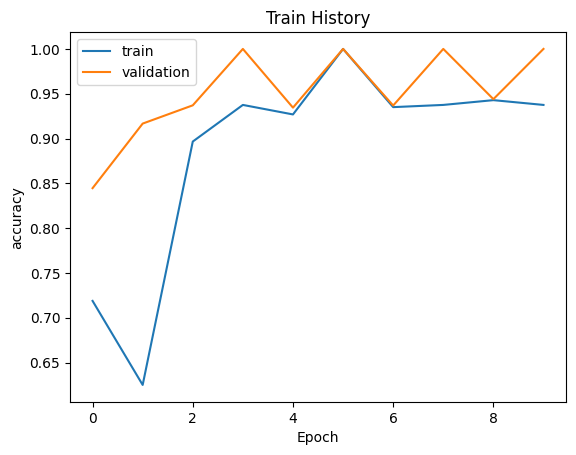

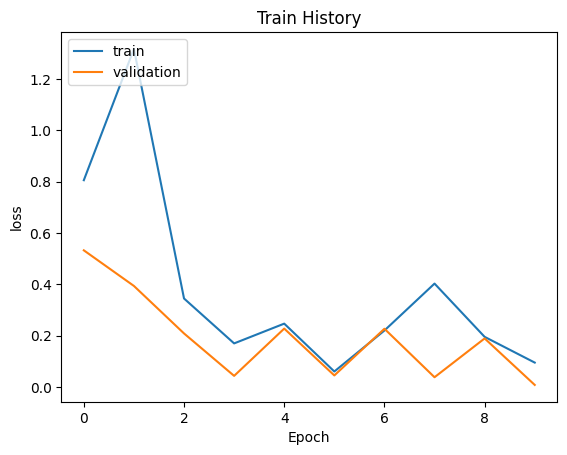

In [80]:
score=M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M8,'accuracy','val_accuracy')
show_train_history(train_history_M8,'loss','val_loss')

In [81]:
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'PermanentCropAnnualCropAnnualCropAnnualCropA...,1391,1500,0.927333,0.944667
1,1,b'Forest',b'ForestForestForestForestHerbaceousVegetation...,1423,1500,0.948667,0.944667
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationHerbaceousVegetationHerb...,1488,1500,0.992000,0.944667
3,3,b'Highway',b'HighwayHighwayHighwayHighwayRiverHighwayHigh...,1225,1250,0.980000,0.944667
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1239,1250,0.991200,0.944667
5,5,b'Pasture',b'HerbaceousVegetationPasturePasturePasturePas...,907,1000,0.907000,0.944667
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1049,1250,0.839200,0.944667
7,7,b'Residential',b'IndustrialResidentialIndustrialResidentialRe...,1388,1500,0.925333,0.944667
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1168,1250,0.934400,0.944667
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1475,1500,0.983333,0.944667


### **Dataframe with all results**

In [82]:
all_pred_df = M1_pred_df.loc[:, ['y_true', 'label_count']]
all_pred_df['M1_class_acc'] = M1_pred_df.loc[:, 'class_acc']

### **Part C. Your Model**

Based on the Model 1-8, develope a model to improve the classification results. The requirements are
1. Compare three different backborn models.
2. Improve the classification results as much as you can.

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 129s 72ms/step - accuracy: 0.6022 - loss: 1.2103 - lr: 1.0000e-04 - val_accuracy: 0.6596 - val_loss: 1.7063 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8750 - loss: 0.3092 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8750 - loss: 0.3092 - lr: 1.0000e-04 - val_accuracy: 0.8333 - val_loss: 0.7393 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8460 - loss: 0.4788 - lr: 1.0000e-04 - val_accuracy: 0.9223 - val_loss: 0.2336 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.8750 - loss: 0.2912 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 0.3896 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8762 - loss: 0.3894 - lr: 1.0000e-04 - val_accuracy: 0.9357 - val_loss: 0.1895 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.3802 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 0.1331 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━

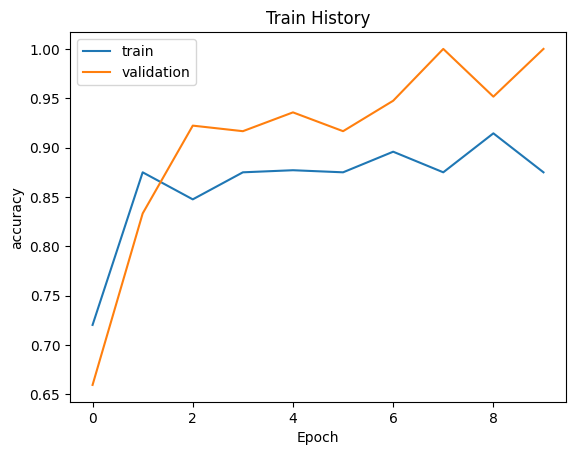

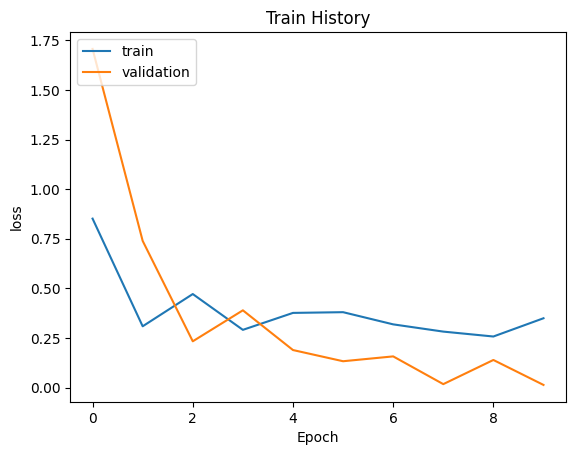

422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropAnnualCropAnnualCropAnnualCropAnnu...,1412,1500,0.941333,0.951481
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1491,1500,0.994000,0.951481
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationHerbaceousVegetationHerb...,1429,1500,0.952667,0.951481
3,3,b'Highway',b'HighwayHighwayHighwayHighwayRiverHighwayHigh...,1184,1250,0.947200,0.951481
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1209,1250,0.967200,0.951481
5,5,b'Pasture',b'HerbaceousVegetationPasturePasturePasturePas...,934,1000,0.934000,0.951481
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1114,1250,0.891200,0.951481
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1456,1500,0.970667,0.951481
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1181,1250,0.944800,0.951481
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1435,1500,0.956667,0.951481


In [83]:
# EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
model_file='/content/drive/My Drive/Colab Notebooks/Models/M8.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer.learning_rate
  return lr

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)
M8=Sequential()

conv_base = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

M8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True
train_history_M8=M8.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)
score=M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M8,'accuracy','val_accuracy')
show_train_history(train_history_M8,'loss','val_loss')
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.4997 - loss: 1.3972 - lr: 1.0000e-04 - val_accuracy: 0.7938 - val_loss: 0.6584 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8125 - loss: 0.5100 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.8125 - loss: 0.5100 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 0.7057 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8299 - loss: 0.5407 - lr: 1.0000e-04 - val_accuracy: 0.8751 - val_loss: 0.3880 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.5355 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0836 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8895 - loss: 0.3744 - lr: 1.0000e-04 - val_accuracy: 0.8931 - val_loss: 0.3813 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.8750 - loss: 0.4760 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 0.1364 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━

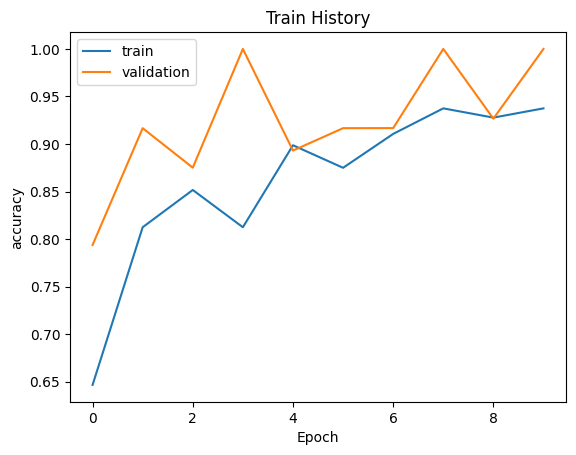

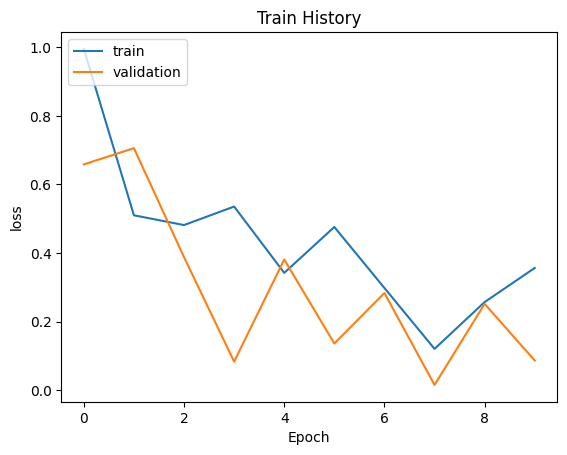

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'PermanentCropAnnualCropAnnualCropAnnualCropA...,1243,1500,0.828667,0.918148
1,1,b'Forest',b'ForestForestForestForestForestForestSeaLakeF...,1454,1500,0.969333,0.918148
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationPermanentCropHerbaceousV...,1261,1500,0.840667,0.918148
3,3,b'Highway',b'HighwayHighwayHighwayHighwayHerbaceousVegeta...,1161,1250,0.928800,0.918148
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1229,1250,0.983200,0.918148
5,5,b'Pasture',b'HerbaceousVegetationPasturePasturePasturePas...,868,1000,0.868000,0.918148
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1104,1250,0.883200,0.918148
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1471,1500,0.980667,0.918148
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1138,1250,0.910400,0.918148
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1466,1500,0.977333,0.918148


In [84]:
# VGG19
from tensorflow.keras.applications import VGG19
model_file='/content/drive/My Drive/Colab Notebooks/Models/M8.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer.learning_rate
  return lr

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)
M8=Sequential()

conv_base = VGG19(include_top=False, input_shape=input_shape, weights='imagenet')

M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

M8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True
train_history_M8=M8.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)
score=M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M8,'accuracy','val_accuracy')
show_train_history(train_history_M8,'loss','val_loss')
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 93s 54ms/step - accuracy: 0.5908 - loss: 1.3443 - lr: 1.0000e-04 - val_accuracy: 0.8724 - val_loss: 0.4019 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.9375 - loss: 0.2056 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.2056 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 0.4693 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8438 - loss: 0.4932 - lr: 1.0000e-04 - val_accuracy: 0.9110 - val_loss: 0.2723 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.9375 - loss: 0.3182 - lr: 1.0000e-04 - val_accuracy: 0.7500 - val_loss: 0.4478 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8855 - loss: 0.3581 - lr: 1.0000e-04 - val_accuracy: 0.9243 - val_loss: 0.2294 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9375 - loss: 0.2745 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.1639 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━

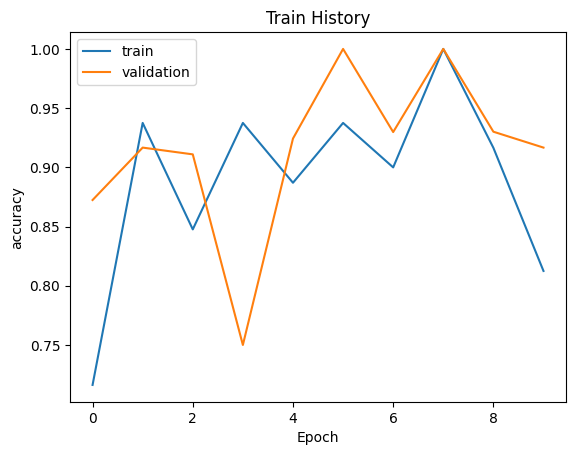

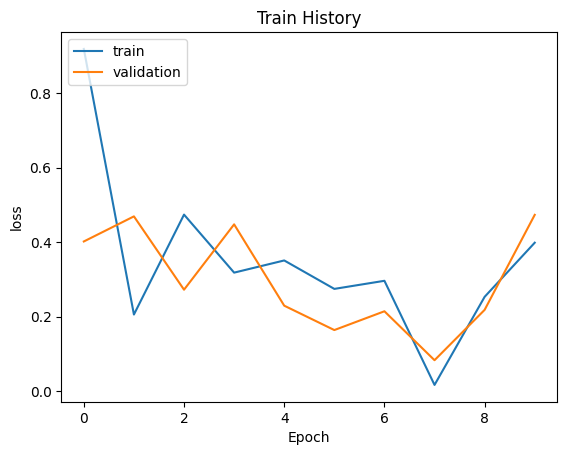

422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'PermanentCropPasturePermanentCropAnnualCropA...,1388,1500,0.925333,0.928741
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1484,1500,0.989333,0.928741
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationPermanentCropPermanentCr...,1292,1500,0.861333,0.928741
3,3,b'Highway',b'HerbaceousVegetationHighwayHighwayHighwayRes...,1077,1250,0.861600,0.928741
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1229,1250,0.983200,0.928741
5,5,b'Pasture',b'ResidentialPasturePasturePasturePasturePastu...,920,1000,0.920000,0.928741
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1135,1250,0.908000,0.928741
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1478,1500,0.985333,0.928741
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1105,1250,0.884000,0.928741
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1430,1500,0.953333,0.928741


In [86]:
# ResNet50V2
from tensorflow.keras.applications import ResNet50V2
model_file='/content/drive/My Drive/Colab Notebooks/Models/M8.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer.learning_rate
  return lr

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)
M8=Sequential()

conv_base = ResNet50V2(include_top=False, input_shape=input_shape, weights='imagenet')

M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

M8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True
train_history_M8=M8.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)
score=M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M8,'accuracy','val_accuracy')
show_train_history(train_history_M8,'loss','val_loss')
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 121s 66ms/step - accuracy: 0.6010 - loss: 9.8119 - lr: 1.0000e-04 - val_accuracy: 0.6478 - val_loss: 8.1686 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.8750 - loss: 6.2692 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8750 - loss: 6.2692 - lr: 1.0000e-04 - val_accuracy: 0.8333 - val_loss: 6.5800 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8380 - loss: 5.7404 - lr: 1.0000e-04 - val_accuracy: 0.9264 - val_loss: 3.6316 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 3.9278 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 3.6124 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8794 - loss: 3.3049 - lr: 1.0000e-04 - val_accuracy: 0.9407 - val_loss: 2.0226 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 2.0456 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 1.8802 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━━

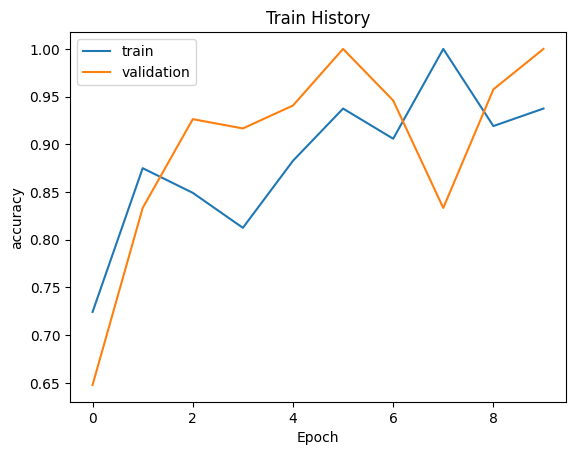

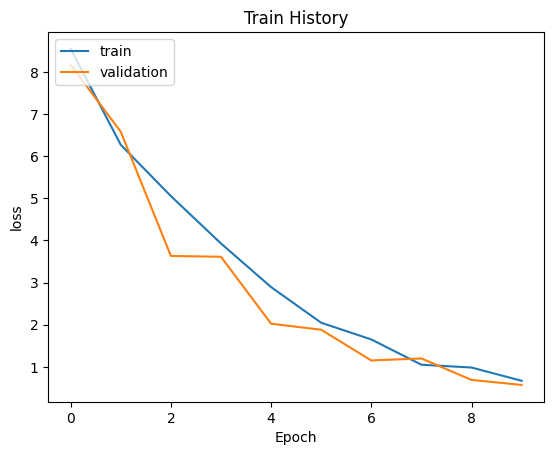

422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'PermanentCropAnnualCropAnnualCropAnnualCropA...,1426,1500,0.950667,0.957111
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1490,1500,0.993333,0.957111
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationHerbaceousVegetationPerm...,1461,1500,0.974000,0.957111
3,3,b'Highway',b'HerbaceousVegetationHighwayHighwayHighwayHig...,1150,1250,0.920000,0.957111
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1222,1250,0.977600,0.957111
5,5,b'Pasture',b'HighwayPasturePasturePasturePasturePasturePa...,913,1000,0.913000,0.957111
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1112,1250,0.889600,0.957111
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1467,1500,0.978000,0.957111
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1212,1250,0.969600,0.957111
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1468,1500,0.978667,0.957111


In [89]:
# EfficientNetB0+L2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
model_file='/content/drive/My Drive/Colab Notebooks/Models/M8.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer.learning_rate
  return lr

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)
M8=Sequential()

conv_base = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
M8.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

M8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True
train_history_M8=M8.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)
score=M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M8,'accuracy','val_accuracy')
show_train_history(train_history_M8,'loss','val_loss')
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 94s 55ms/step - accuracy: 0.7010 - loss: 1.1118 - lr: 1.0000e-04 - val_accuracy: 0.3945 - val_loss: 2.5044 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.9375 - loss: 0.2329 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.2329 - lr: 1.0000e-04 - val_accuracy: 0.2500 - val_loss: 3.2054 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8811 - loss: 0.4010 - lr: 1.0000e-04 - val_accuracy: 0.9280 - val_loss: 0.2213 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.1152 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0799 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9165 - loss: 0.2758 - lr: 1.0000e-04 - val_accuracy: 0.9442 - val_loss: 0.1718 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.3918 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0075 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━━

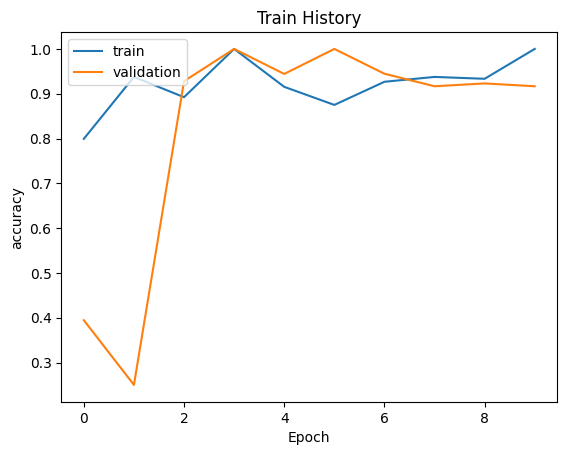

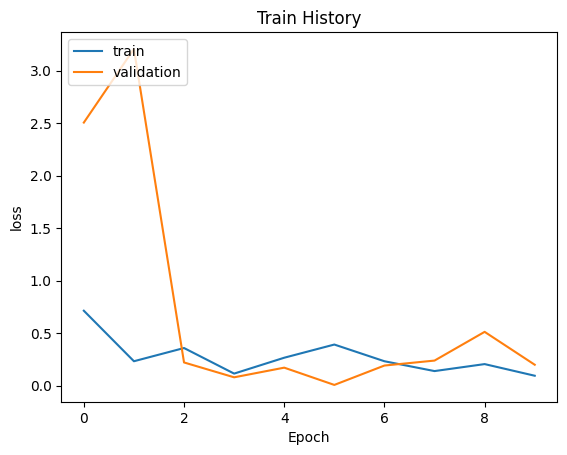

422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropAnnualCropAnnualCropAnnualCropAnnu...,1388,1500,0.925333,0.94563
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1466,1500,0.977333,0.94563
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationPermanentCropHerbaceousV...,1427,1500,0.951333,0.94563
3,3,b'Highway',b'HighwayHighwayIndustrialHighwayRiverHighwayH...,1107,1250,0.885600,0.94563
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1245,1250,0.996000,0.94563
5,5,b'Pasture',b'HighwayPasturePasturePasturePasturePasturePa...,965,1000,0.965000,0.94563
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1078,1250,0.862400,0.94563
7,7,b'Residential',b'IndustrialResidentialResidentialResidentialR...,1431,1500,0.954000,0.94563
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1208,1250,0.966400,0.94563
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1451,1500,0.967333,0.94563


In [91]:
from tensorflow.keras.applications import ResNet50

# Filepath for saving the model
model_file = '/content/drive/My Drive/Colab Notebooks/Models/M8.h5.keras'

# Define callbacks
early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True)

reduce_LR = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5)

checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list = [reduce_LR, early_stop, checkpoint]

# Define a function to monitor learning rate
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate
    return lr

# Optimizer and learning rate metric
optimizer = Adam(learning_rate=1e-4)
lr_metric = get_lr_metric(optimizer)

# Define the model
M8 = Sequential()

# Pre-trained ResNet50 as the convolutional base
conv_base = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')

# Add the pre-trained base to the model
M8.add(conv_base)

# Flatten the output of the convolutional base
M8.add(Flatten())

# Add a Dropout layer for regularization
M8.add(Dropout(0.5))

# Add Dense layers with L2 regularization
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

# Compile the model
M8.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', lr_metric]
)

# Fine-tune the last few layers of the pre-trained ResNet50
for layer in conv_base.layers[7:]:
    layer.trainable = True

# Train the model
train_history_M8 = M8.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size,
    callbacks=callback_list
)

# Evaluate the model
score = M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training history
show_train_history(train_history_M8, 'accuracy', 'val_accuracy')
show_train_history(train_history_M8, 'loss', 'val_loss')

# Evaluate predictions
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df


Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 131s 76ms/step - accuracy: 0.3114 - loss: 14.0854 - lr: 1.0000e-04 - val_accuracy: 0.1105 - val_loss: 15.2105 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.4375 - loss: 10.6994 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4375 - loss: 10.6994 - lr: 1.0000e-04 - val_accuracy: 0.1667 - val_loss: 14.9395 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.5795 - loss: 9.6842 - lr: 1.0000e-04 - val_accuracy: 0.1099 - val_loss: 166.0917 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 39us/step - accuracy: 0.8125 - loss: 6.9161 - lr: 1.0000e-04 - val_accuracy: 0.3333 - val_loss: 81.7287 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.6875 - loss: 6.5482 - lr: 1.0000e-04 - val_accuracy: 0.1431 - val_loss: 9.4774 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 40us/step - accuracy: 0.5625 - loss: 5.0942 - lr: 1.0000e-04 - val_accuracy: 0.0833 - val_loss: 10.4110 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━

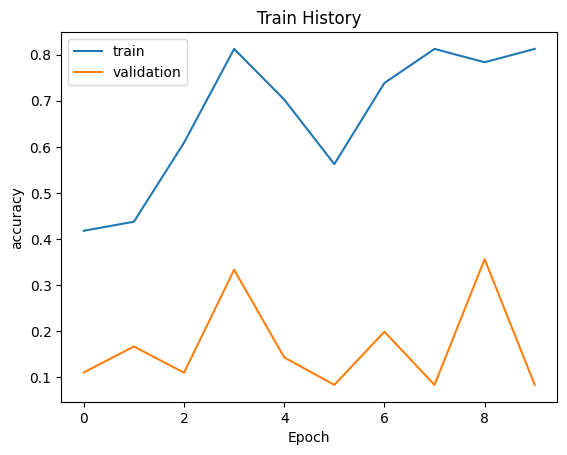

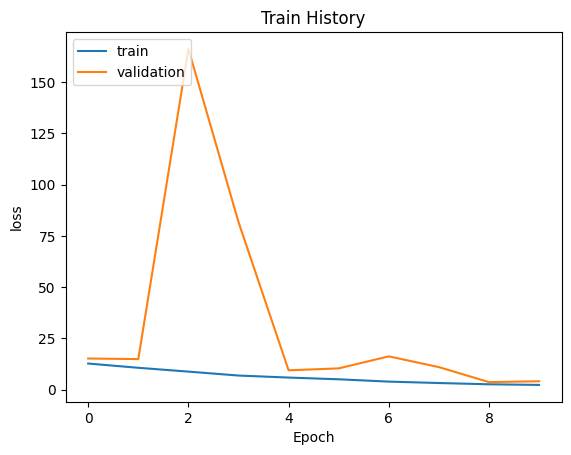

422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropAnnualCropAnnualCropHighwayAnnualC...,1216,1500,0.810667,0.110815
1,1,b'Forest',b'IndustrialAnnualCropAnnualCropAnnualCropAnnu...,1,1500,0.000667,0.110815
2,2,b'HerbaceousVegetation',b'AnnualCropRiverRiverAnnualCropAnnualCropAnnu...,7,1500,0.004667,0.110815
3,3,b'Highway',b'AnnualCropAnnualCropRiverAnnualCropAnnualCro...,35,1250,0.028000,0.110815
4,4,b'Industrial',b'RiverAnnualCropAnnualCropAnnualCropAnnualCro...,77,1250,0.061600,0.110815
5,5,b'Pasture',b'RiverAnnualCropAnnualCropAnnualCropRiverAnnu...,0,1000,0.000000,0.110815
6,6,b'PermanentCrop',b'IndustrialRiverAnnualCropAnnualCropAnnualCro...,0,1250,0.000000,0.110815
7,7,b'Residential',b'AnnualCropAnnualCropAnnualCropAnnualCropAnnu...,8,1500,0.005333,0.110815
8,8,b'River',b'AnnualCropAnnualCropAnnualCropAnnualCropAnnu...,134,1250,0.107200,0.110815
9,9,b'SeaLake',b'AnnualCropRiverAnnualCropAnnualCropAnnualCro...,18,1500,0.012000,0.110815


In [94]:
# EfficientNetB0+L2+Dense
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

# Filepath for saving the model
model_file = '/content/drive/My Drive/Colab Notebooks/Models/M8.h5.keras'

# Define callbacks
early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True)

reduce_LR = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5)

checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list = [reduce_LR, early_stop, checkpoint]

# Define a function to monitor learning rate
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate
    return lr

# Optimizer and learning rate metric
optimizer = Adam(learning_rate=1e-4)
lr_metric = get_lr_metric(optimizer)

# Define the model
M8 = Sequential()

# Pre-trained EfficientNetB0 as the convolutional base
conv_base = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

# Add the pre-trained base to the model
M8.add(conv_base)

# Flatten the output of the convolutional base
M8.add(Flatten())

# Add a Dropout layer for regularization
M8.add(Dropout(0.5))

# Add Dense layers with L2 regularization
M8.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
M8.add(Dropout(0.4))
M8.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
M8.add(Dropout(0.3))
M8.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile the model
M8.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', lr_metric]
)

# Fine-tune the last few layers of the pre-trained ResNet50
for layer in conv_base.layers[7:]:
    layer.trainable = True

# Train the model
train_history_M8 = M8.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size,
    callbacks=callback_list
)

# Evaluate the model
score = M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training history
show_train_history(train_history_M8, 'accuracy', 'val_accuracy')
show_train_history(train_history_M8, 'loss', 'val_loss')

# Evaluate predictions
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df
